<a href="https://colab.research.google.com/github/HemaVarshiniB/Recent-U.S.-College-Scorecard-Cohorts-Data/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
## Import Python Packages

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Most-Recent-Cohorts-Field-of-Study.csv')

# Display basic information about the dataset
print(df.info())

# Display the first few rows
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229188 entries, 0 to 229187
Columns: 174 entries, UNITID to EARN_IN_STATE_5YR
dtypes: float64(3), int64(5), object(166)
memory usage: 304.3+ MB
None
     UNITID  OPEID6                    INSTNM CONTROL  MAIN  CIPCODE  \
0  100654.0    1002  Alabama A & M University  Public     1      100   
1  100654.0    1002  Alabama A & M University  Public     1      101   
2  100654.0    1002  Alabama A & M University  Public     1      109   
3  100654.0    1002  Alabama A & M University  Public     1      110   
4  100654.0    1002  Alabama A & M University  Public     1      110   

                                 CIPDESC  CREDLEV           CREDDESC  \
0                  Agriculture, General.        3  Bachelor's Degree   
1  Agricultural Business and Management.        3  Bachelor's Degree   
2                       Animal Sciences.        3  Bachelor's Degree   
3           Food Science and Technology.        3  Bachelor's Degree   
4       

In [ ]:
# Select features for the model
features = ['CREDLEV', 'CIPDESC', 'CONTROL', 'DEBT_NOPELL_PP_EVAL_MDN', 'EARN_MDN_4YR']
target = 'EARN_NOPELL_WNE_MDN_4YR'

df = df.replace('PS', np.nan)

df['EARN_NOPELL_WNE_MDN_4YR'] = pd.to_numeric(df['EARN_NOPELL_WNE_MDN_4YR'], errors='coerce')


# Create X (features) and y (target)
X = df[features]
y = df[target]

In [ ]:
# Create binary classification target (above/below median completion rate)
median_completion_rate = y.median()
y_binary = (y > median_completion_rate).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Identify numeric and categorical columns
numeric_features = ['DEBT_NOPELL_PP_EVAL_MDN', 'EARN_MDN_4YR']
categorical_features = ['CREDLEV', 'CIPDESC', 'CONTROL']

# Create a preprocessing pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create a preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with preprocessing and classification steps
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [ ]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

# Perform 4-fold cross-validation
cv_scores = cross_val_score(pipeline, X, y_binary, cv=kfold, scoring='accuracy')

# Print cross-validation results
print('**********************************')
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})')
print('**********************************')
print()

**********************************
Cross-validation scores: [0.97069655 0.97064419 0.97029513 0.96937012]
Mean CV Accuracy: 0.9703 (+/- 0.0011)
**********************************



In [ ]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DEBT_NOPELL_PP_EVAL_MDN',
                                                   'EARN_MDN_4YR']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['CREDLEV', 'CIPDESC',
                                                   'CONTROL'])])),
                ('classifier', RandomForestClassifier(random_state=42))])


Sample Predictions:
Index(['CREDLEV', 'CIPDESC', 'CONTROL', 'DEBT_NOPELL_PP_EVAL_MDN',
       'EARN_MDN_4YR', 'Predicted_Class', 'Probability_Above_Median'],
      dtype='object')


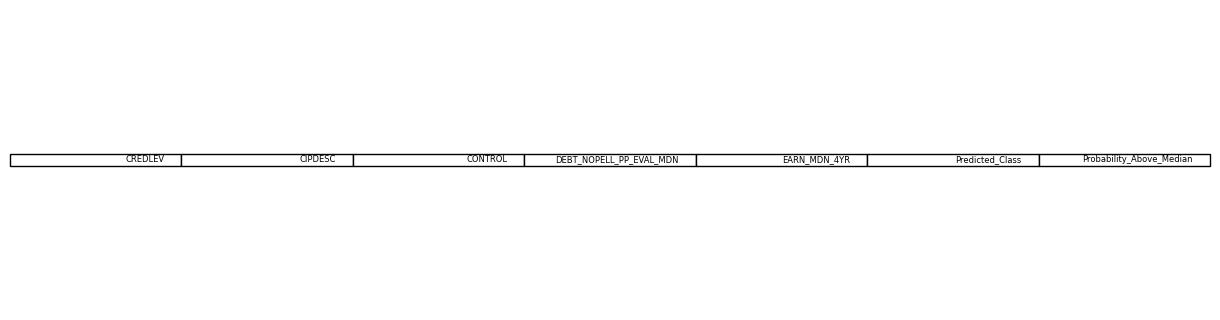

In [ ]:
# Create sample data for predictions
sample_data = pd.DataFrame({
    'CREDLEV': ['3', '2', '1', '4'],
    'CIPDESC': ['Business Administration', 'Computer Science', 'Psychology', 'Engineering'],
    'CONTROL': ['Public', 'Private', 'Public', 'Private'],
    'DEBT_NOPELL_PP_EVAL_MDN': [20000, 30000, 15000, 40000],
    'EARN_MDN_4YR': [50000, 70000, 45000, 80000]
})

# Make predictions on the sample data
predictions = pipeline.predict(sample_data)
probabilities = pipeline.predict_proba(sample_data)

# Add predictions and probabilities to the sample data
sample_data['Predicted_Class'] = predictions
sample_data['Probability_Above_Median'] = probabilities[:, 1]

print("\nSample Predictions:")
print(sample_data.columns)

# Get the column names
columns = sample_data.columns

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(20, 5))

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Plot the column names
table = ax.table(cellText=[columns], loc='center')

# Adjust layout to make room for the table
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)

# Show the plot
plt.show()


In [ ]:
# add actual result in and overfitting?

# Feature importance
importances = pipeline.named_steps['classifier'].feature_importances_

# Get feature names after one-hot encoding
onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = np.concatenate((numeric_features, onehot_columns))

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'feature': all_features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)


In [ ]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print('**********************************')
print(f'Accuracy Score: {accuracy}')

print(f'Precision Score: {precision}')

print(f'Recall Score: {recall}')

print(f'F1 Score: {f1}')

print(f'ROC-AUC Score: {roc_auc}')
print('**********************************')
print()


**********************************
Accuracy Score: 0.9707666128539639
Precision Score: 0.6888994759409243
Recall Score: 0.6779184247538678
F1 Score: 0.6833648393194707
ROC-AUC Score: 0.9765156504422497
**********************************



              precision    recall  f1-score   support

           0       0.98      0.99      0.98     43705
           1       0.69      0.68      0.68      2133

    accuracy                           0.97     45838
   macro avg       0.84      0.83      0.83     45838
weighted avg       0.97      0.97      0.97     45838



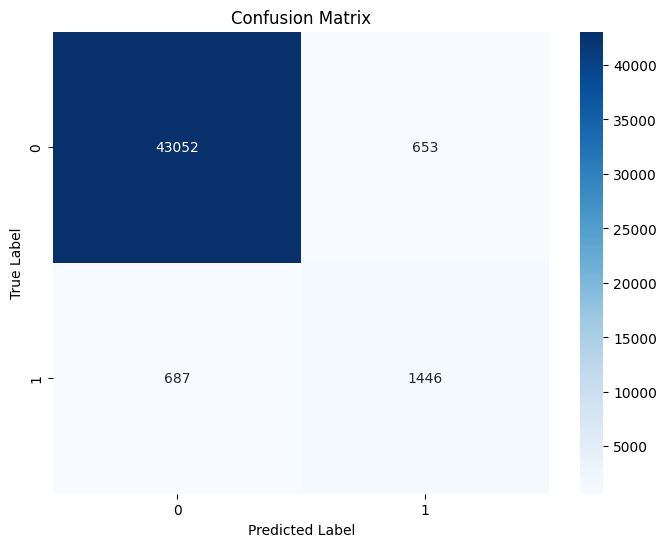

In [ ]:
# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


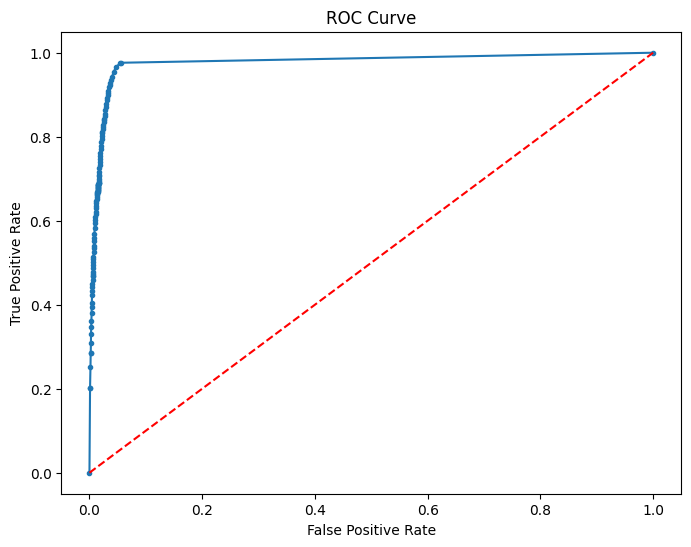

In [ ]:

# Plot ROC curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, marker='.')

plt.plot([0, 1], [0, 1], linestyle='--', color='r')

plt.title('ROC Curve')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.show()


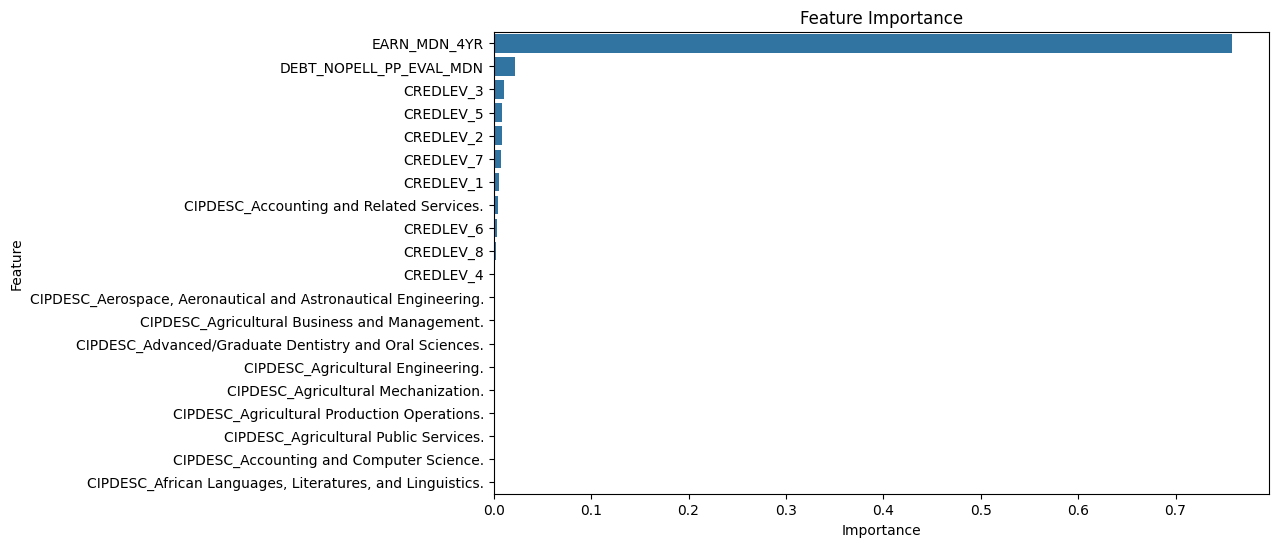

In [ ]:
# # Feature importance
# feature_importance = pipeline.named_steps['classifier'].feature_importances_
# feature_importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance})
# feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Feature importance
classifier = pipeline.named_steps['classifier']
importances = classifier.feature_importances_

# Get feature names after one-hot encoding
onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = np.concatenate((numeric_features, onehot_columns))

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'feature': all_features, 'importance': importances}).head(20)
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

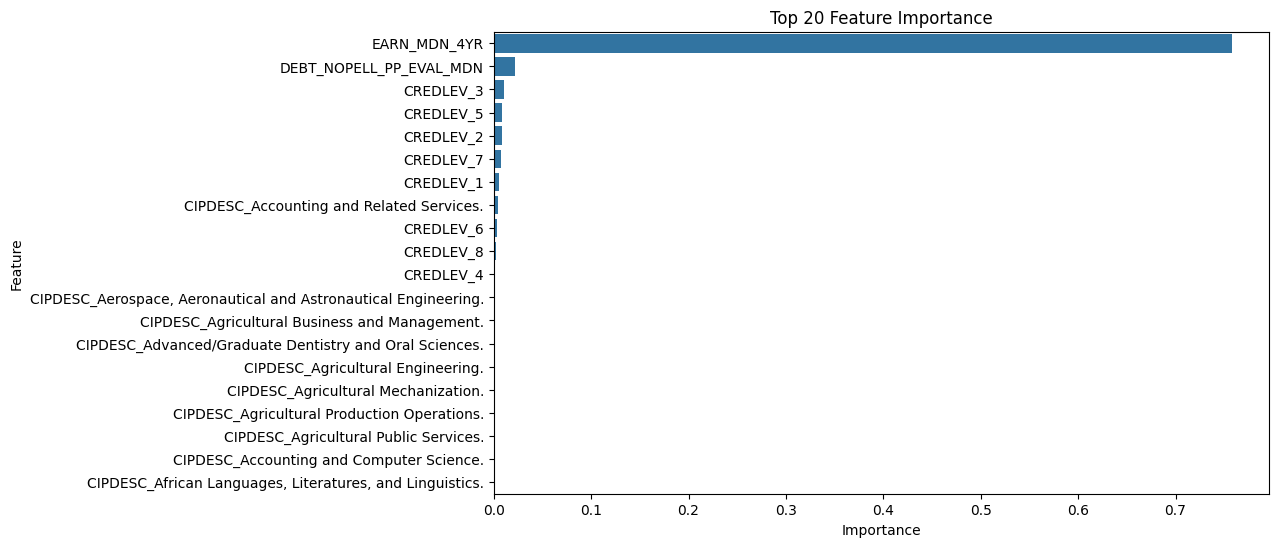

In [ ]:
# Select the top N features to display
N = 20
top_features = feature_importance_df.head(N)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the data loading and preprocessing steps remain the same
# ...

# Define features and target
features = ['CREDLEV', 'CIPDESC', 'CONTROL', 'DEBT_NOPELL_PP_EVAL_MDN', 'EARN_MDN_4YR']
target = 'EARN_NOPELL_WNE_MDN_4YR'

# Create X (features) and y (target)
X = df[features]
y = df[target]

# Create binary classification target (above/below median completion rate)
median_completion_rate = y.median()
y_binary = (y > median_completion_rate).astype(int)

# Identify numeric and categorical columns
numeric_features = ['DEBT_NOPELL_PP_EVAL_MDN', 'EARN_MDN_4YR']
categorical_features = ['CREDLEV', 'CIPDESC', 'CONTROL']

# Create a preprocessing pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create a preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with preprocessing and classification steps
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

**********************************
Accuracy Score: 0.9695667350233431
**********************************

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     43705
           1       0.67      0.68      0.67      2133

    accuracy                           0.97     45838
   macro avg       0.83      0.83      0.83     45838
weighted avg       0.97      0.97      0.97     45838



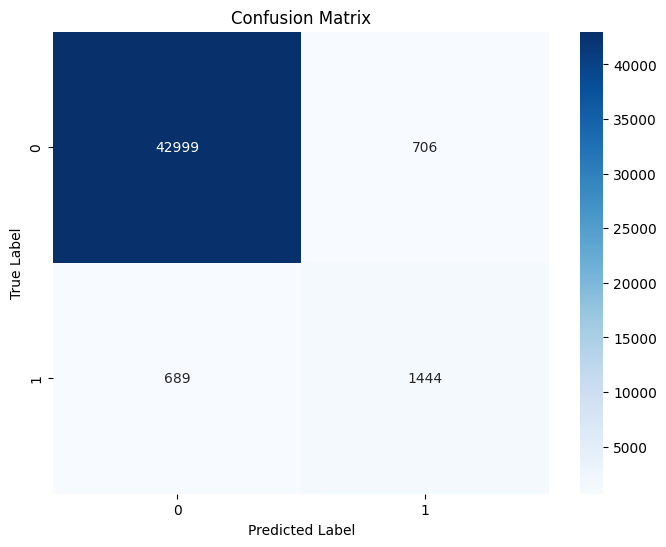

In [ ]:
# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('**********************************')
print(f'Accuracy Score: {accuracy}')
print('**********************************')
print()

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print('**********************************')
print(f'Accuracy Score: {accuracy}')

print(f'Precision Score: {precision}')

print(f'Recall Score: {recall}')

print(f'F1 Score: {f1}')

print(f'ROC-AUC Score: {roc_auc}')
print('**********************************')
print()




**********************************
Accuracy Score: 0.9695667350233431
Precision Score: 0.6716279069767442
Recall Score: 0.6769807782466011
F1 Score: 0.6742937193555919
ROC-AUC Score: 0.830867369145294
**********************************



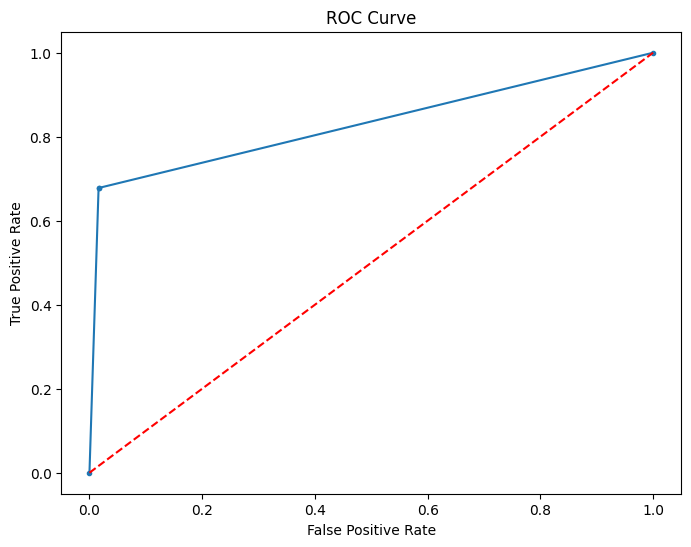

In [ ]:

# Plot ROC curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, marker='.')

plt.plot([0, 1], [0, 1], linestyle='--', color='r')

plt.title('ROC Curve')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.show()


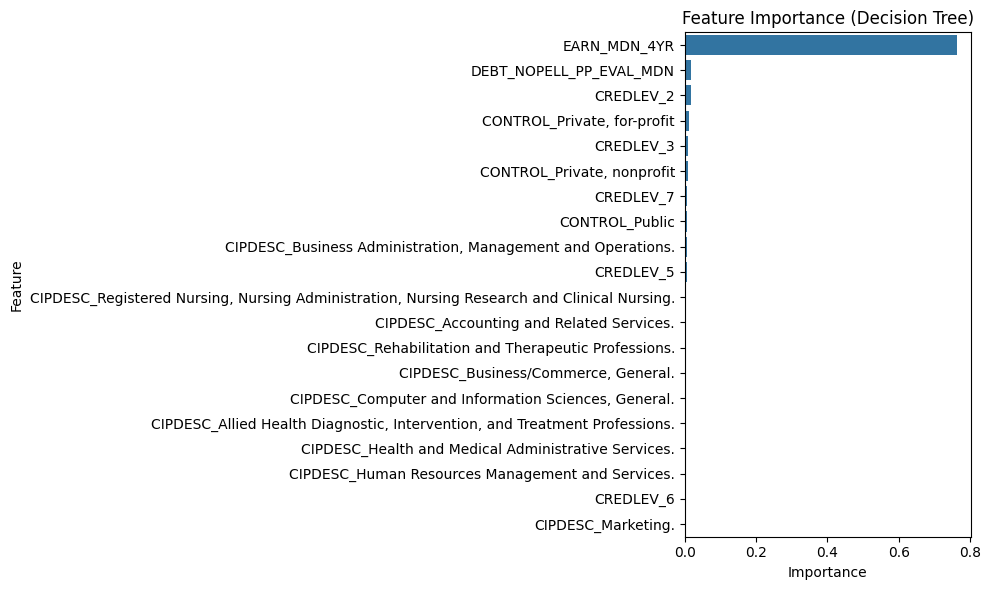

In [ ]:
# Feature importance for Decision Tree
importances = pipeline.named_steps['classifier'].feature_importances_

# Get feature names after one-hot encoding
onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = np.concatenate((numeric_features, onehot_columns))

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'feature': all_features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))  # Showing top 20 features
plt.title('Feature Importance (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

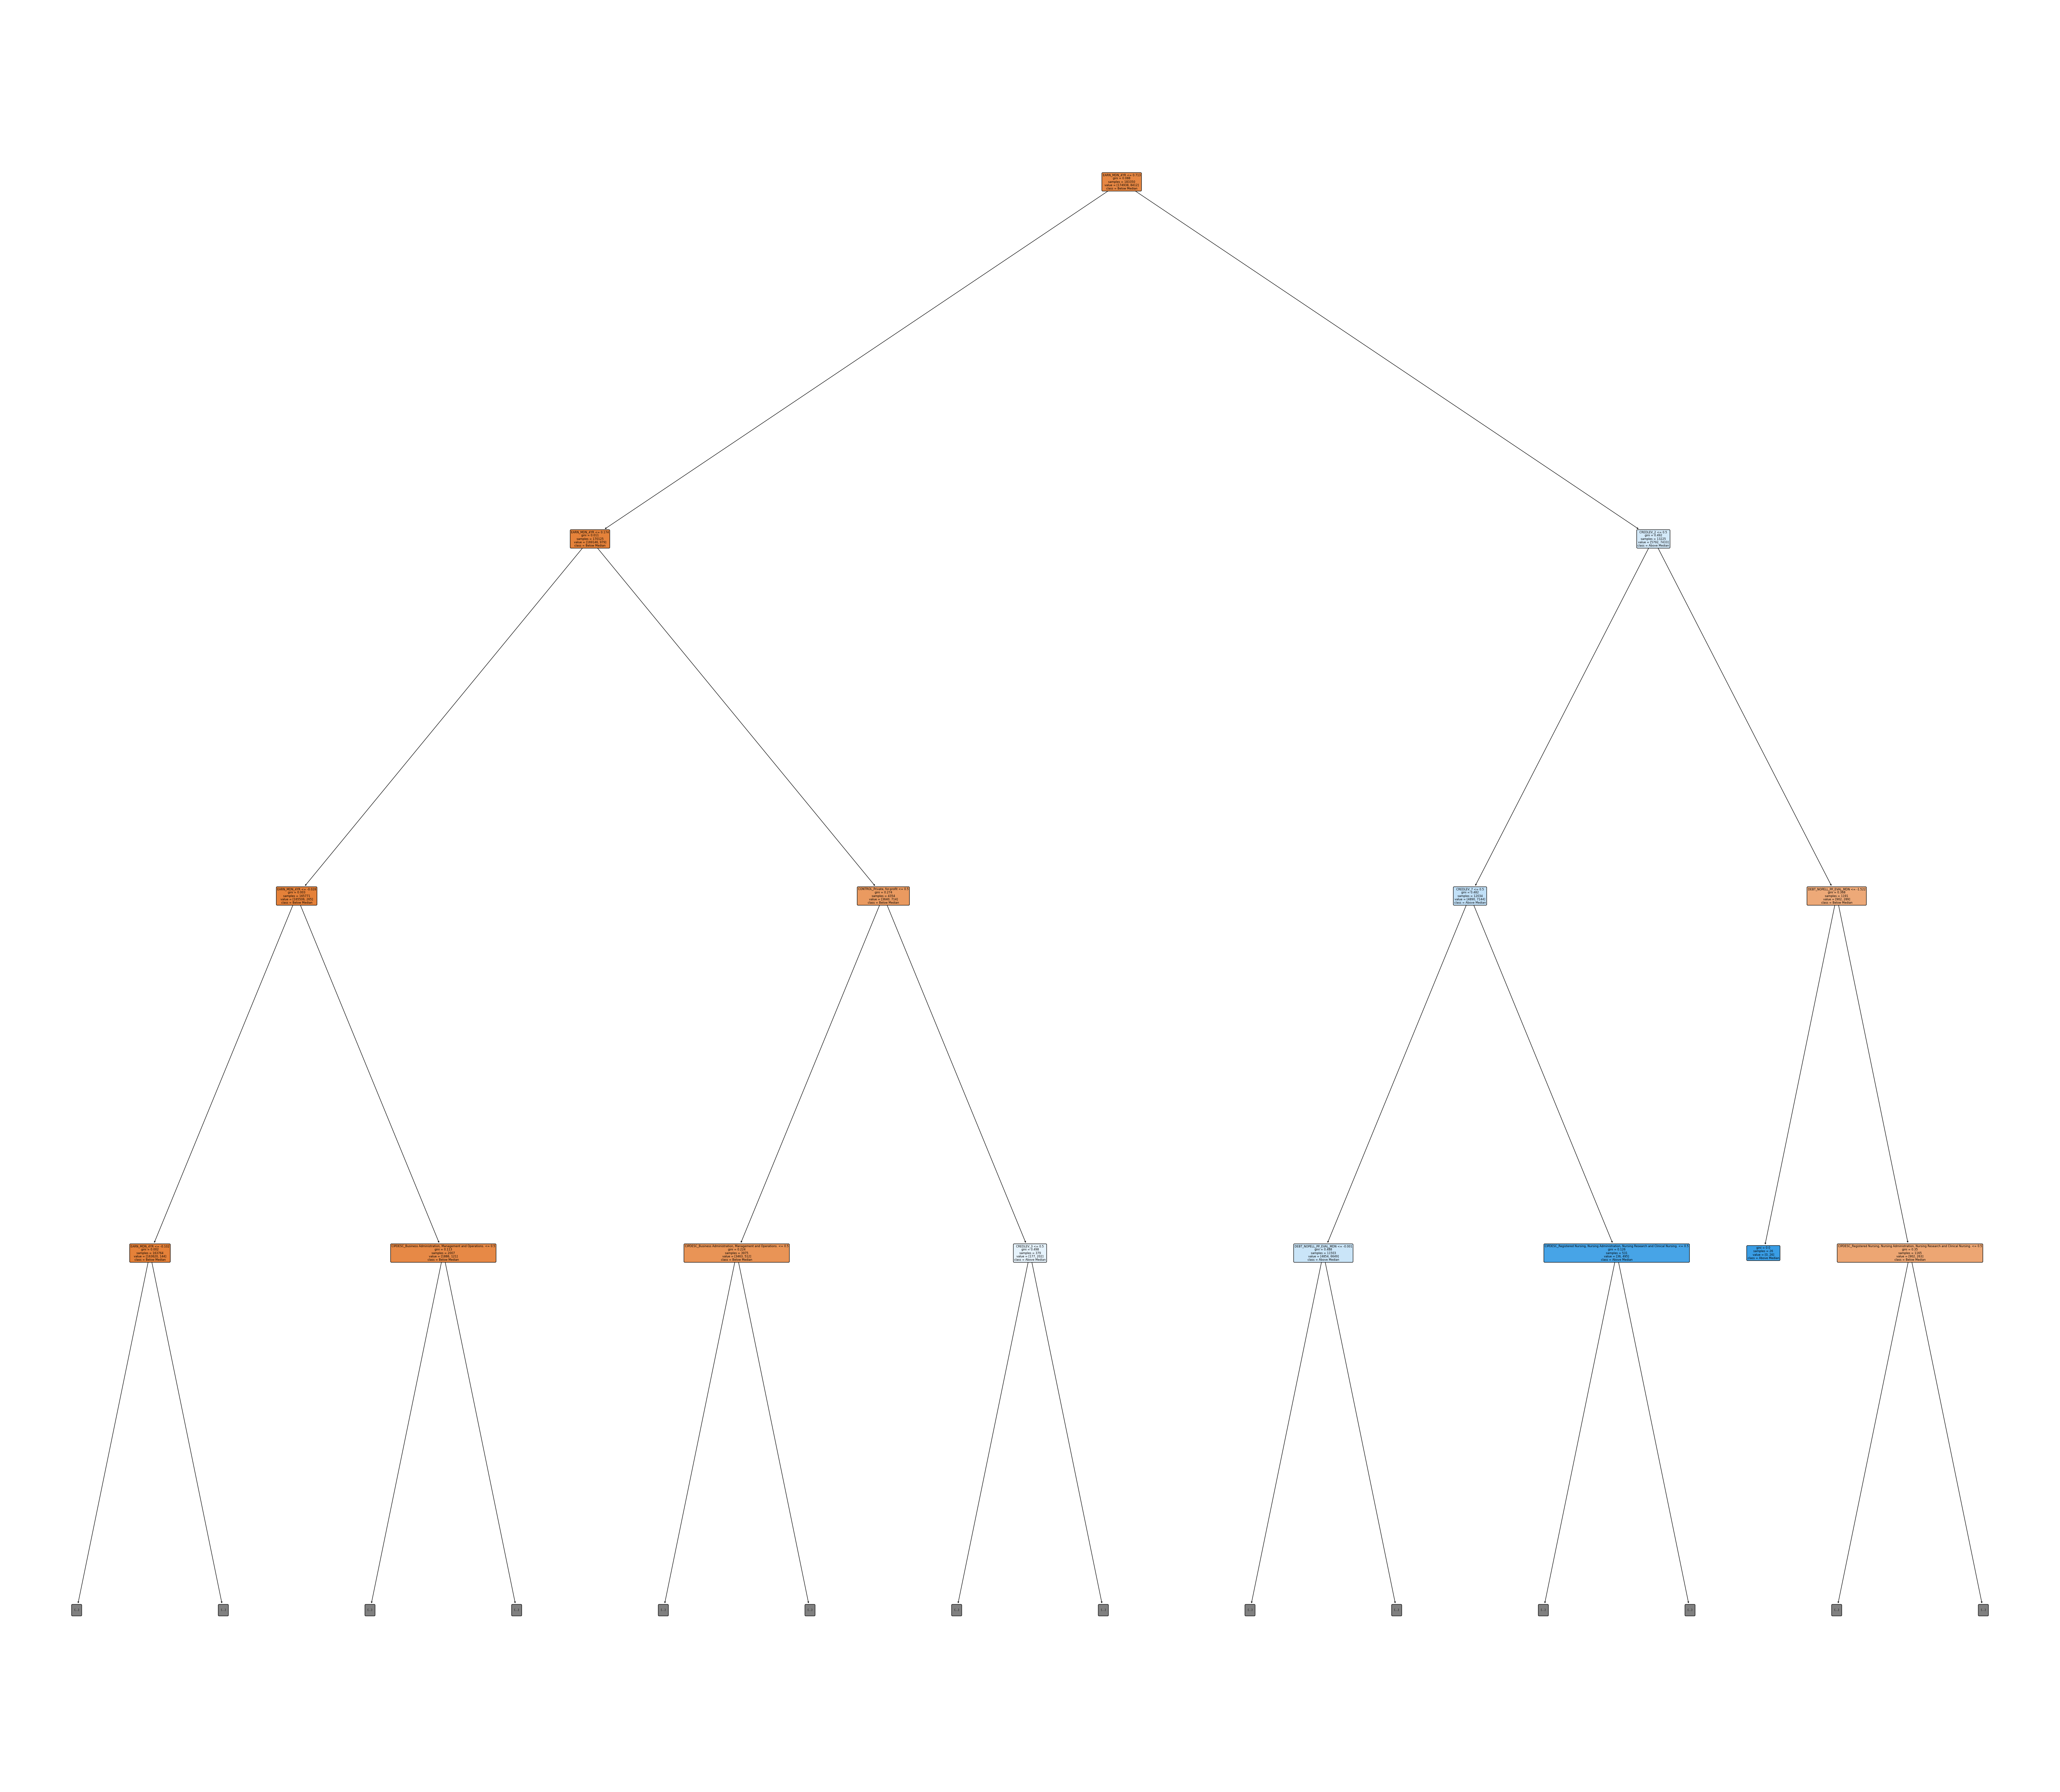

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(80, 70))
plot_tree(pipeline.named_steps['classifier'],
          feature_names=all_features,
          class_names=['Below Median', 'Above Median'],
          filled=True,
          rounded=True,
          max_depth=3)  # Limit depth for visibility
plt.show()